# Class of Method(GNAR) lag 1

SEOYEON CHOI  
2023-01-28

> GNAR fiveNet,fivenodes

# import

In [114]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation

# torch
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvGRU

# scipy 
from scipy.interpolate import interp1d

# utils
import time
import pickle
from tqdm import tqdm

# rpy2
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

In [115]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

# my functions

In [116]:
def load_data(fname):
    with open(fname, 'rb') as outfile:
        data_dict = pickle.load(outfile)
    return data_dict

In [117]:
def save_data(data_dict,fname):
    with open(fname,'wb') as outfile:
        pickle.dump(data_dict,outfile)

In [118]:
def plot(f,*args,t=None,h=2.5,**kwargs):
    T,N = f.shape
    if t == None: t = range(T)
    fig = plt.figure()
    ax = fig.subplots(N,1)
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
        ax[n].set_title('node='+str(n))
    fig.set_figheight(N*h)
    fig.tight_layout()
    plt.close()
    return fig

In [119]:
def plot_add(fig,f,*args,t=None,**kwargs):
    T = f.shape[0]
    N = f.shape[1] 
    if t == None: t = range(T)   
    ax = fig.get_axes()
    for n in range(N):
        ax[n].plot(t,f[:,n],*args,**kwargs)
    return fig

In [120]:
def make_Psi(T):
    W = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            if i==j :
                W[i,j] = 0
            elif np.abs(i-j) <= 1 : 
                W[i,j] = 1
    d = np.array(W.sum(axis=1))
    D = np.diag(d)
    L = np.array(np.diag(1/np.sqrt(d)) @ (D-W) @ np.diag(1/np.sqrt(d)))
    lamb, Psi = np.linalg.eigh(L)
    return Psi

In [121]:
ebayesthresh = importr('EbayesThresh').ebayesthresh

In [122]:
def trim(f):
    f = np.array(f)
    if len(f.shape)==1: f = f.reshape(-1,1)
    T,N = f.shape
    Psi = make_Psi(T)
    fbar = Psi.T @ f # apply dft 
    fbar_threshed = np.stack([ebayesthresh(FloatVector(fbar[:,i])) for i in range(N)],axis=1)
    fhat = Psi @ fbar_threshed # inverse dft 
    return fhat

In [123]:
def update_from_freq_domain(signal, missing_index):
    signal = np.array(signal)
    T,N = signal.shape 
    signal_trimed = trim(signal)
    for i in range(N):
        signal[missing_index[i],i] = signal_trimed[missing_index[i],i]
    return signal

# test myfunctions

`-` read data

In [124]:
data = load_data('./data/fivenodes.pkl')

`-` save data

In [125]:
#save_data(data, './data/fivenodes.pkl')

`-` plot

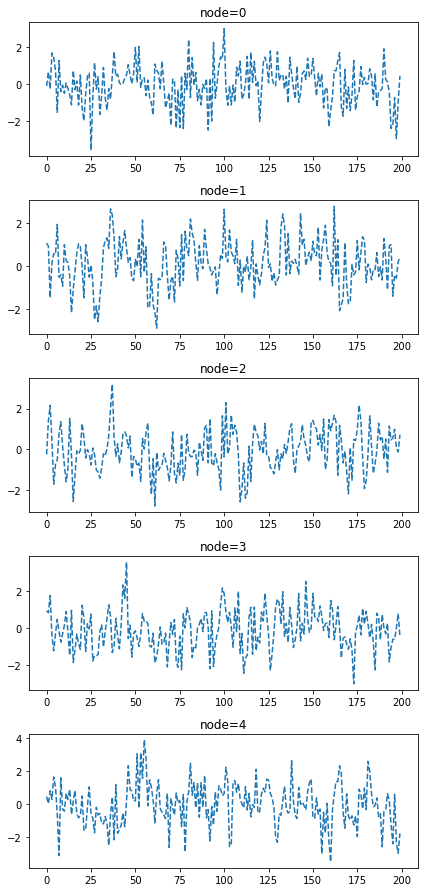

In [126]:
fig=plot(data['f'],'--',color='C0')
fig

`-` plot_add

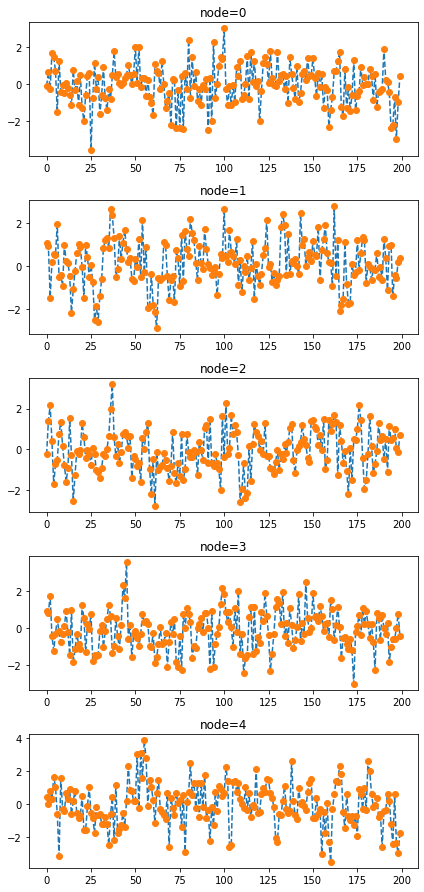

In [127]:
fig=plot_add(fig,data['f'],'o',color='C1')
fig

`-` trim

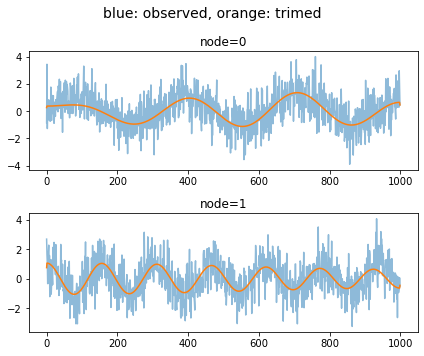

In [128]:
t = np.linspace(0,10,1000)
f = np.stack([np.sin(2*t) + np.random.randn(1000), np.cos(4*t) + np.random.randn(1000)],axis=1)
fig = plot(f, alpha=0.5)
fig = plot_add(fig, trim(f))
fig.suptitle('blue: observed, orange: trimed',size=14)
fig.tight_layout()
fig

# data 정리

`-` 데이터정리

In [129]:
edges_tensor = torch.tensor(data['edges'])
fiveVTS = np.array(data['f'])
nonzero_indices = edges_tensor.nonzero()
fiveNet_edge = np.array(nonzero_indices).T
T = 200
N = 5 # number of Nodes
E = fiveNet_edge
V = np.array([1,2,3,4,5])
t = np.arange(0,T)
node_features = 1
edge_index = torch.tensor(E)
edge_attr = torch.tensor(np.array([1,1,1,1,1,1,1,1,1,1]),dtype=torch.float32)

`-` train / test

In [130]:
fiveVTS_train = fiveVTS[:int(len(fiveVTS)*0.8)]
fiveVTS_test = fiveVTS[int(len(fiveVTS)*0.8):]

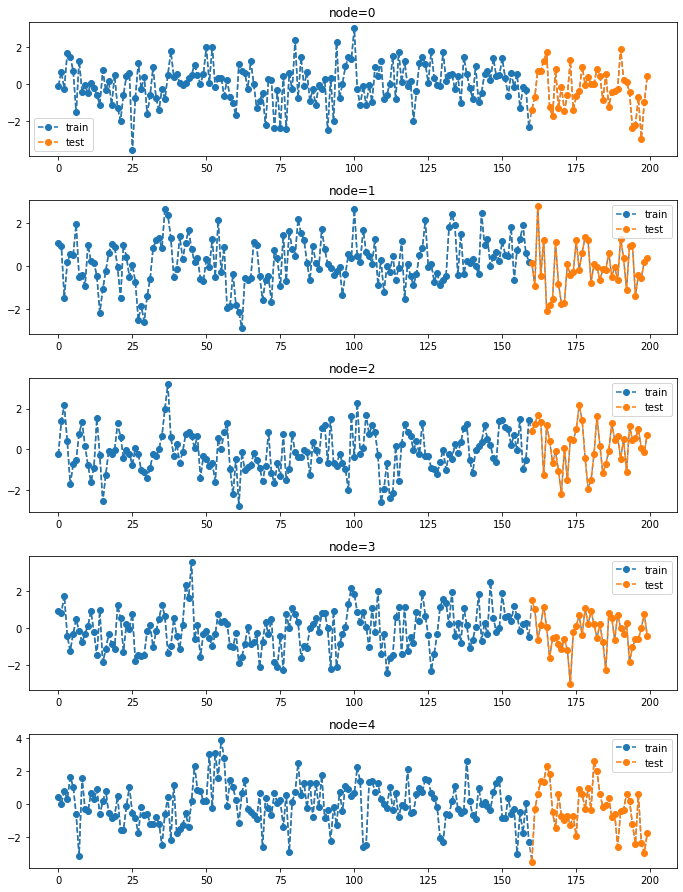

In [131]:
fig = plot(fiveVTS,'--.',color='gray')
fig = plot_add(fig,fiveVTS_train,'--o',label='train',color='C0')
fig = plot_add(fig,fiveVTS_test,'--o',label='test',color='C1',t=range(160,200))
ax = fig.get_axes()
for a in ax:
    a.legend()
fig.set_figwidth(10)
fig

# Random Missing Values

In [132]:
class Missing:
    def __init__(self,df):
        self.df = df
        self.N = N
        self.number = []
    def miss(self,percent=0.5):
        self.missing = self.df.copy()
        self.percent = percent
        for i in range(self.N):
            #self.seed = np.random.choice(1000,1,replace=False)
            #np.random.seed(self.seed)
            self.number.append(np.random.choice(int(len(self.df))-1,int(len(self.df)*self.percent),replace=False))
            self.missing[self.number[i],i] = float('nan')
    def first_mean(self):
        self.train_mean = self.missing.copy()
        for i in range(self.N):
            self.train_mean[self.number[i],i] = np.nanmean(self.missing[:,i])
    def second_linear(self):
        self.train_linear = pd.DataFrame(self.missing)
        self.train_linear.interpolate(method='linear', inplace=True)
        self.train_linear = self.train_linear.fillna(0)
        self.train_linear = np.array(self.train_linear).reshape(int(len(self.df)),N)

`-` 30% 결측치 발생

In [133]:
_zero = Missing(fiveVTS_train)
_zero.miss(percent = 0.3)

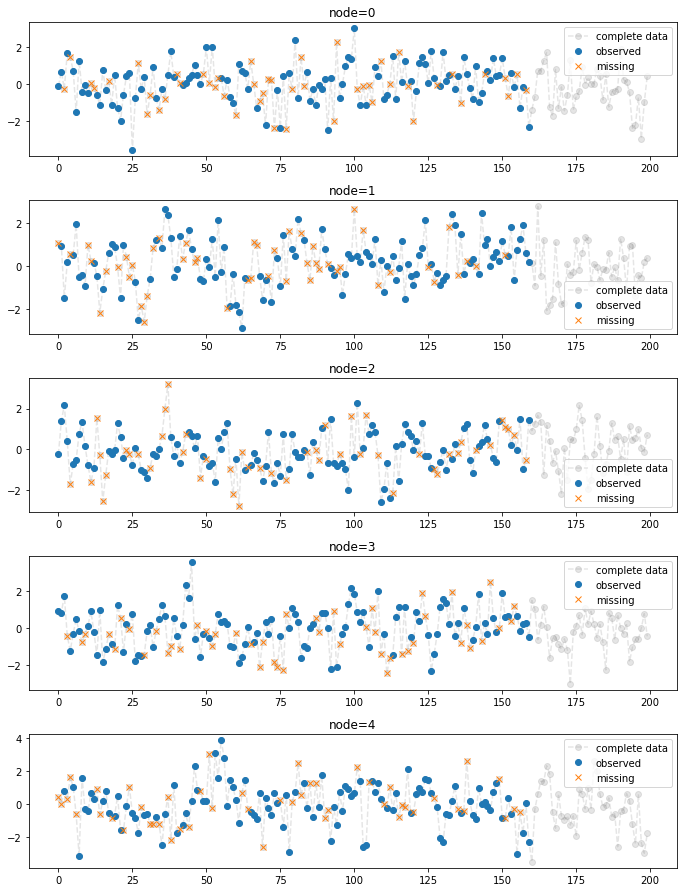

In [134]:
fig = plot(fiveVTS,'--o',color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],fiveVTS_train[:,i][_zero.number[i]],'x',color='C1',label='missing')
    a.legend()
fig.set_figwidth(10)    
fig

`-` 결측치를 평균으로 보간

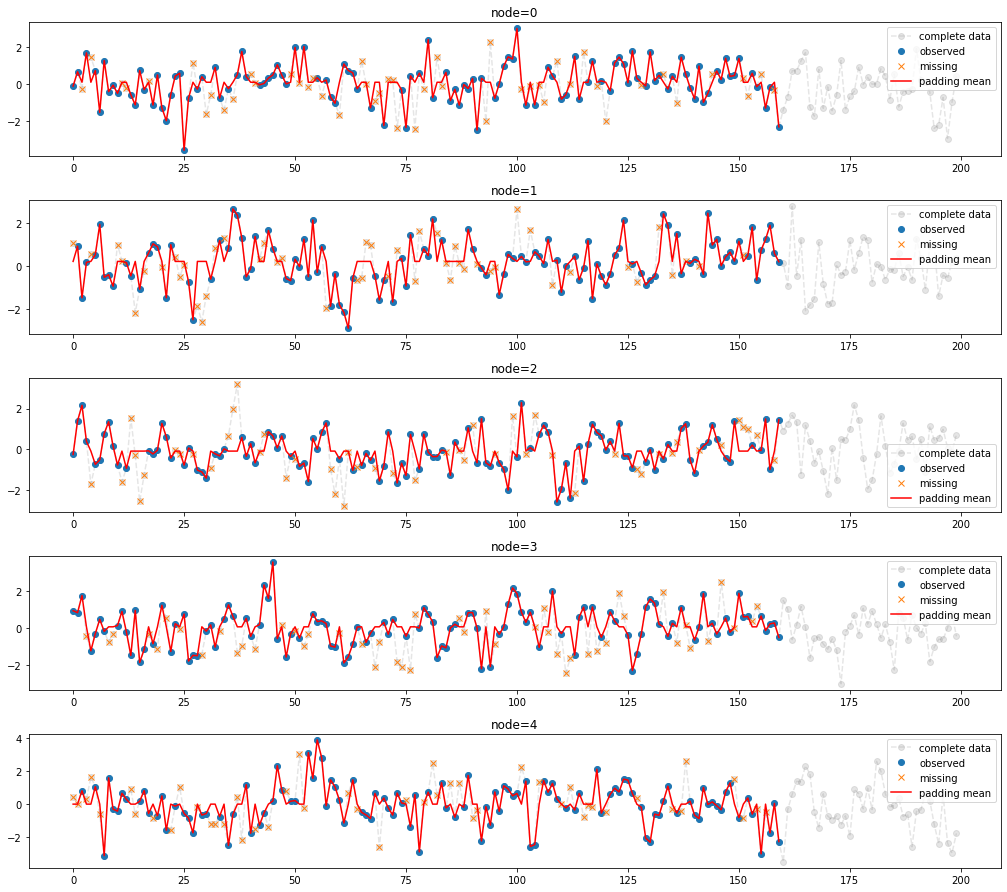

In [135]:
_zero.first_mean()
fig = plot(fiveVTS,'--o',color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],fiveVTS_train[:,i][_zero.number[i]],'x',color='C1',label='missing')
    a.plot(_zero.train_mean[:,i],'-',color='red',label='padding mean')
    a.legend()
fig.set_figwidth(15)
fig

`-` 결측치를 linear interpolation

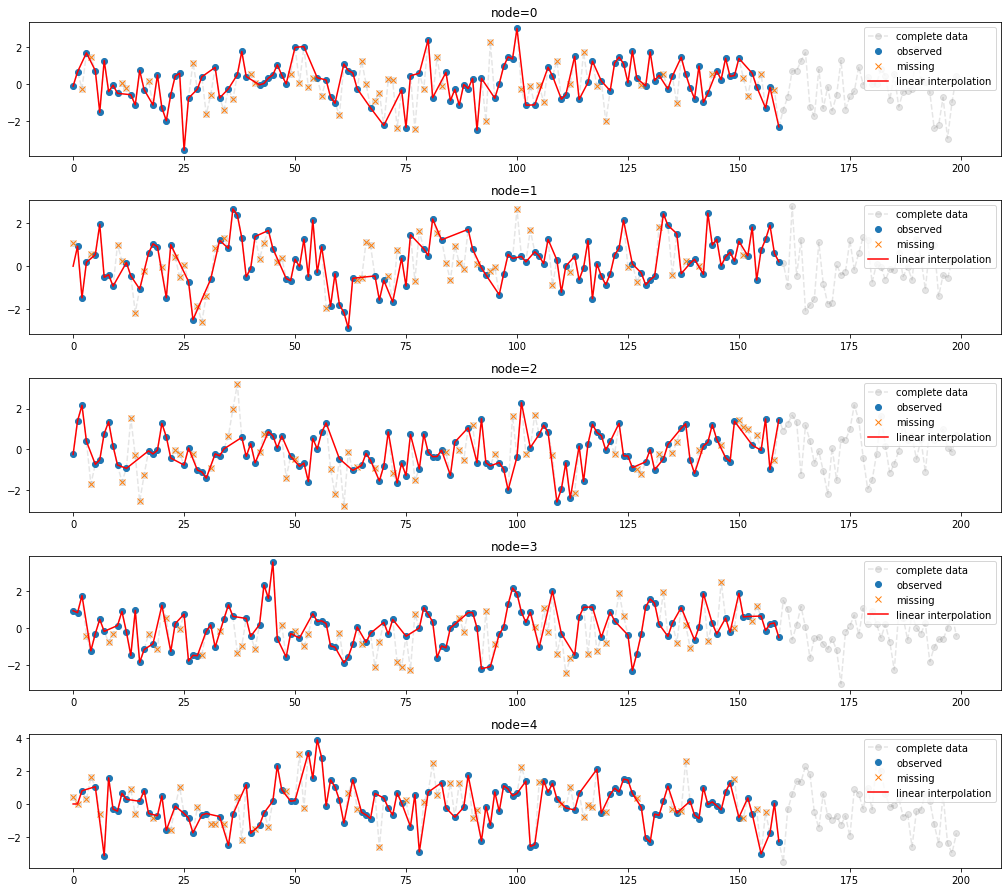

In [136]:
_zero.second_linear()


fig = plot(fiveVTS,'--o',color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(_zero.missing[:,i],'o',color='C0',label='observed')
    a.plot(_zero.number[i],fiveVTS_train[:,i][_zero.number[i]],'x',color='C1',label='missing')
    a.plot(_zero.train_linear[:,i],'-',color='red',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

# Enhencement of STGCN

## 시나리오1 (Baseline)

**시나리오1**

-   missing rate: 0%
-   보간방법: None

### STGCN 으로 적합 + 예측

In [137]:
X = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [138]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

In [139]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:34<00:00,  1.43it/s]

In [140]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [141]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

In [142]:
train_mse_eachnode_stgcn = (((y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

### GNAR 으로 적합 + 예측

`-`

In [143]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython

In [144]:
%%R
library(GNAR)
library(igraph)
library(tidyverse)

In [145]:
%R -i fiveVTS_train

In [146]:
%%R
answer <- GNARfit(vts = fiveVTS_train, net = fiveNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=40)

In [147]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [148]:
%R -o gnar_train
%R -o gnar_test

In [149]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((fiveVTS_test - gnar_test.reshape(-1,5))**2).mean(axis=0)
test_mse_total_gnar = ((fiveVTS_test - gnar_test.reshape(-1,5))**2).mean()

### 결과시각화

In [150]:
train_mse_total_gnar,test_mse_total_gnar

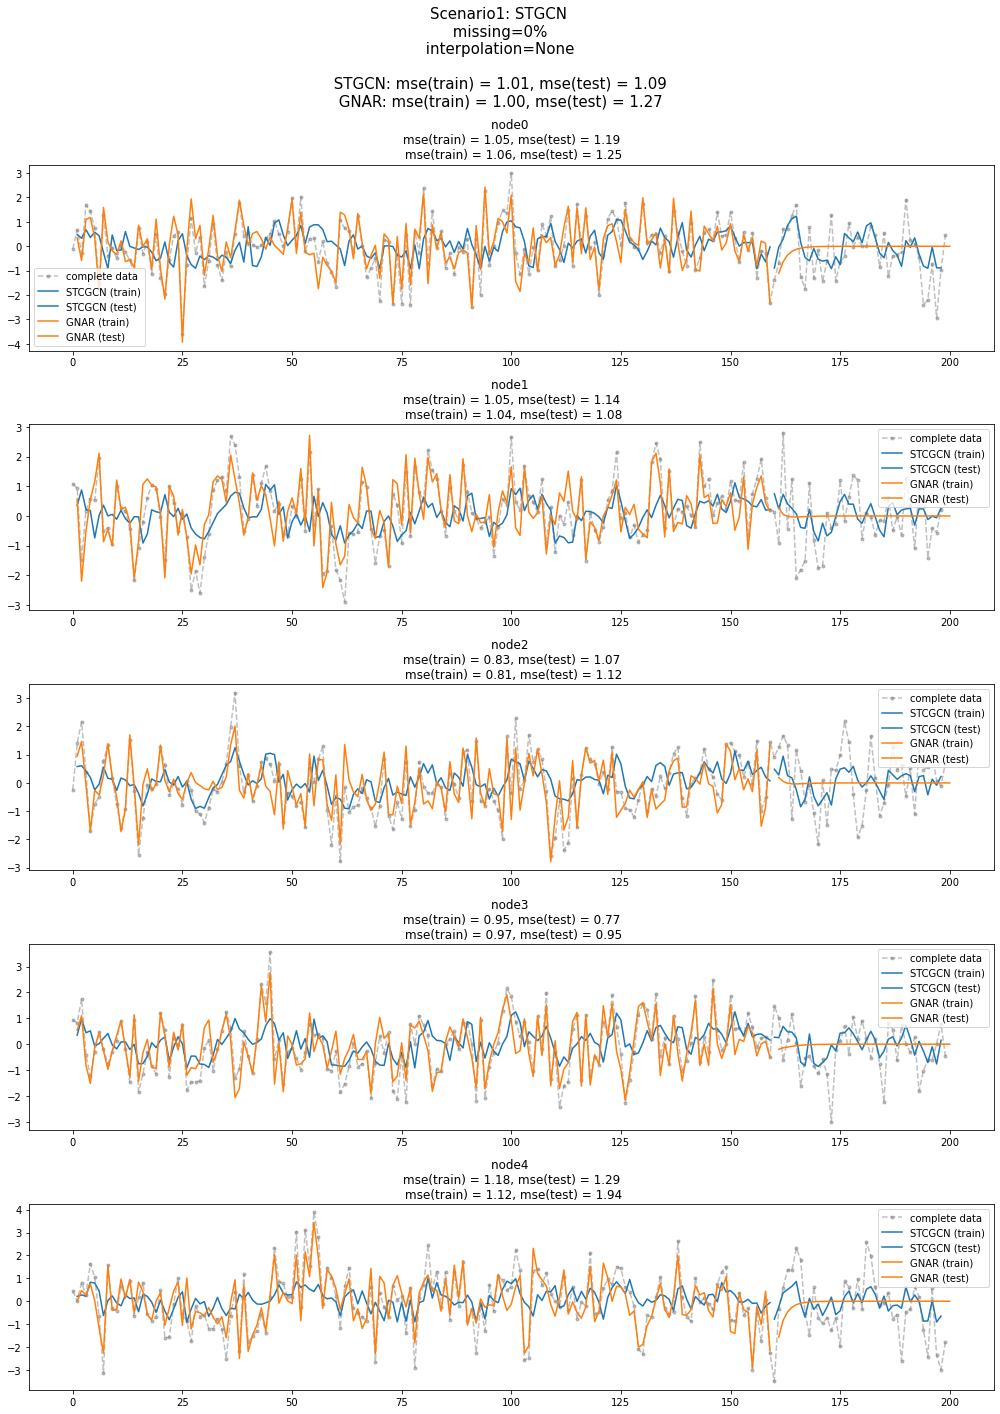

In [153]:
fig = plot(fiveVTS,'--.',h=4,color='gray',label='complete data',alpha=0.5)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n mse(train) = {1:.2f}, mse(test) = {2:.2f} \n mse(train) = {3:.2f}, mse(test) = {4:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(range(1,160),stgcn_train[:,i],label='STCGCN (train)',color='C0')
    a.plot(range(160,199),stgcn_test[:,i],label='STCGCN (test)',color='C0')
    a.plot(range(1,160),gnar_train.reshape(-1,5)[:,i],label='GNAR (train)',color='C1')
    a.plot(range(161,201),gnar_test.reshape(-1,5)[:,i],label='GNAR (test)',color='C1')
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario1: STGCN \n missing=0% \n interpolation=None \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n GNAR: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오2

**시나리오2**

-   missing rate: 50%
-   보간방법: linear

`-` 결측치생성 + 보간

In [154]:
_zero = Missing(fiveVTS_train)
_zero.miss(percent = 0.5)
_zero.second_linear()

In [155]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

In [156]:
fig = plot(fiveVTS,'--o',h=4,color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [157]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [158]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

In [159]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:35<00:00,  1.41it/s]

In [160]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [161]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_stgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

In [162]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

### ESTGCN 으로 적합 + 예측

In [163]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [164]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

`-` ESTGCN

In [165]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
    y = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]

In [166]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [167]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [168]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [169]:
X_train1 = np.array(X).squeeze()
X_test1 =  np.array(XX).squeeze()

In [170]:
%R -i X_train1

In [172]:
%%R
answer <- GNARfit(vts = X_train1, net = fiveNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=40)

In [173]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [174]:
%R -o gnar_train
%R -o gnar_test

In [175]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((X_test1 - gnar_test[1:,:])**2).mean(axis=0)
test_mse_total_gnar = ((X_test1 - gnar_test[1:,:])**2).mean()

### 결과시각화

In [176]:
train_mse_total_gnar,test_mse_total_gnar

In [178]:
fig = plot(fiveVTS,'--.',h=4,color='gray',label='complete data',alpha=0.5)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,160),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(160,199),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,160),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(161,200),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,159),gnar_train[:,i],label='GNAR (train)',color='C2')
    a.plot(range(161,201),gnar_test[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario2: \n missing=50% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오3

**시나리오3**

-   missing rate: 80%
-   보간방법: linear

`-` 결측치생성 + 보간

In [179]:
_zero = Missing(fiveVTS_train)
_zero.miss(percent = 0.8)
_zero.second_linear()

In [180]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

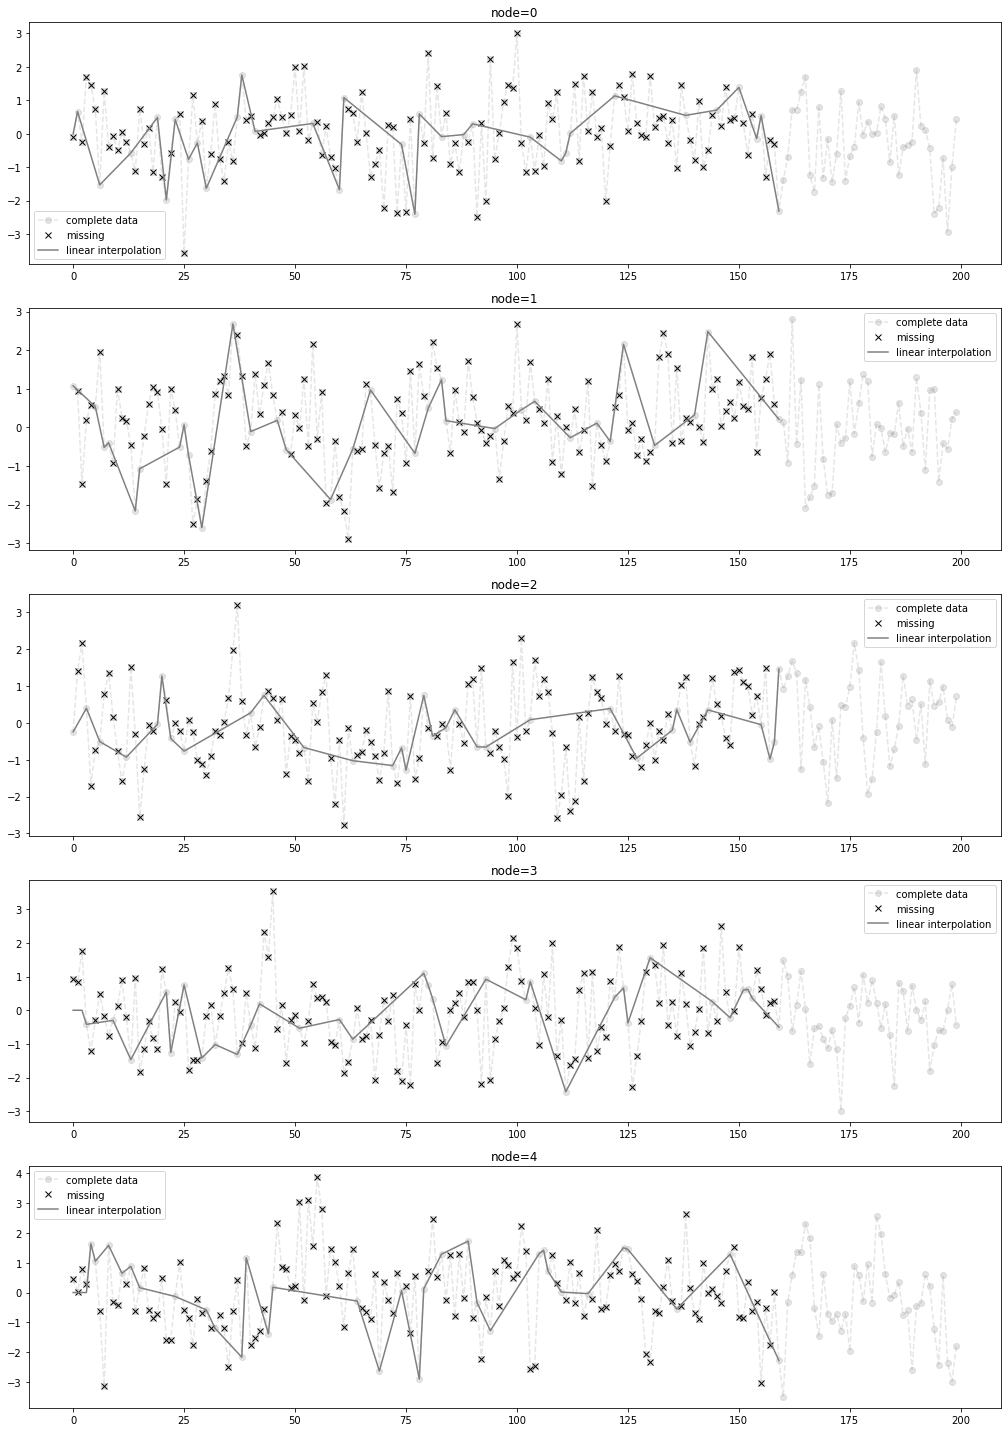

In [181]:
fig = plot(fiveVTS,'--o',h=4,color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [182]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [183]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

In [184]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]

In [185]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [186]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_stgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

In [187]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

### ESTGCN 으로 적합 + 예측

In [188]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [189]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

`-` ESTGCN

In [190]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
    y = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [00:37<00:00,  1.33it/s]

In [191]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [192]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [193]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [194]:
X_train1 = np.array(X).squeeze()
X_test1 =  np.array(XX).squeeze()

In [195]:
%R -i X_train1

In [196]:
%%R
answer <- GNARfit(vts = X_train1, net = fiveNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=40)

In [197]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [198]:
%R -o gnar_train
%R -o gnar_test

In [199]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((X_test1 - gnar_test[1:,:])**2).mean(axis=0)
test_mse_total_gnar = ((X_test1 - gnar_test[1:,:])**2).mean()

### 결과시각화

In [200]:
train_mse_total_gnar,test_mse_total_gnar

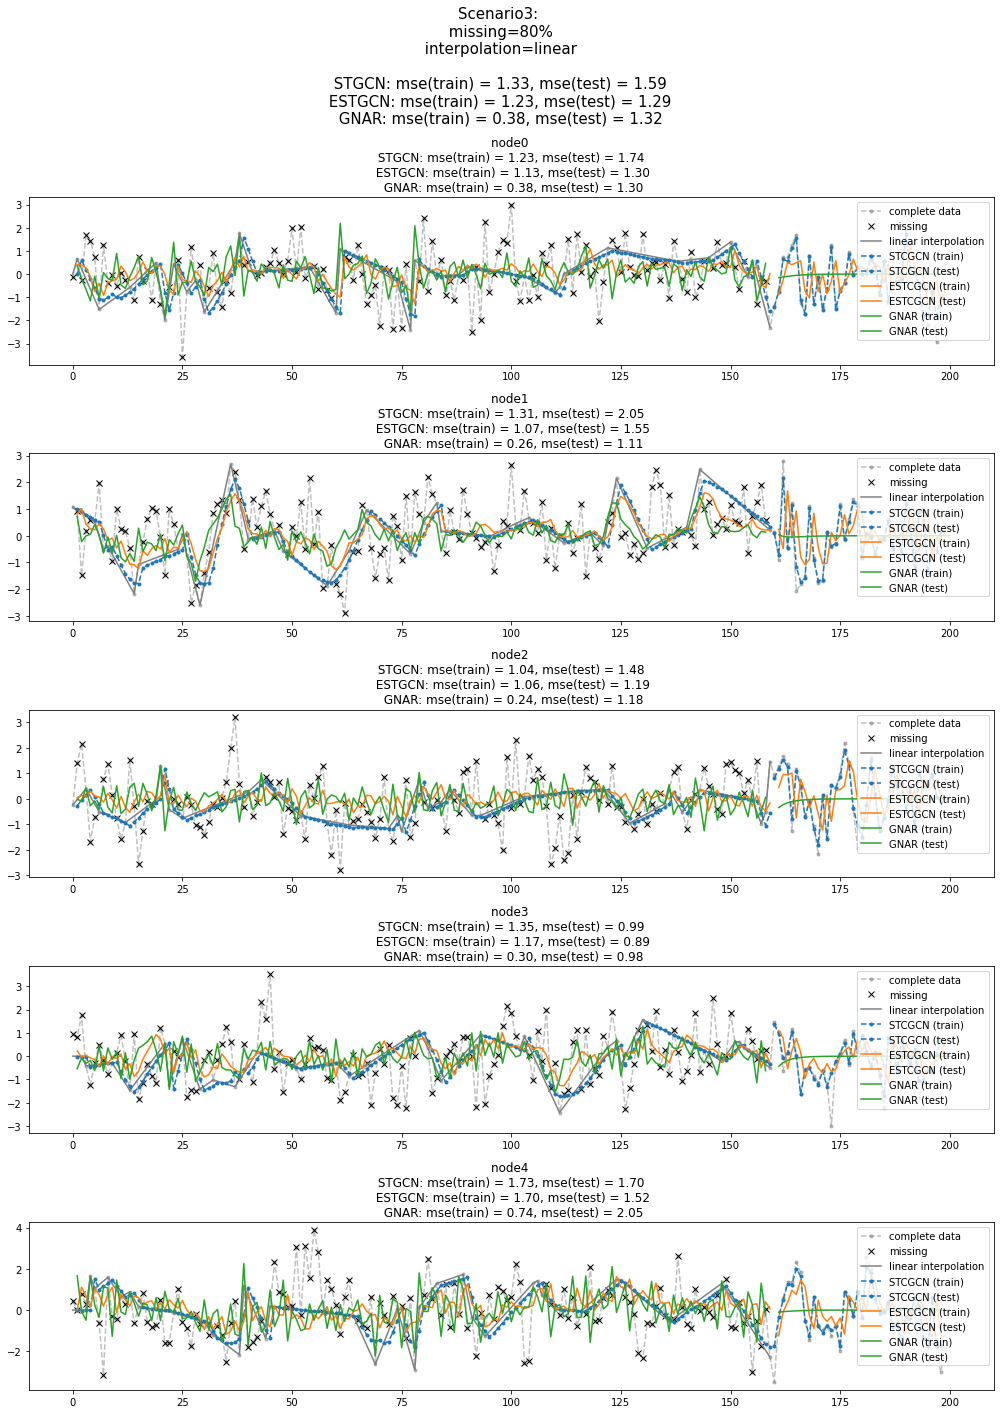

In [205]:
fig = plot(fiveVTS,'--.',h=4,color='gray',label='complete data',alpha=0.5)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,160),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(160,199),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,160),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(161,200),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,159),gnar_train[:,i],label='GNAR (train)',color='C2')
    a.plot(range(161,201),gnar_test[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario3: \n missing=80% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig

## 시나리오4

**시나리오4**

-   missing rate: 30%
-   보간방법: linear

`-` 결측치생성 + 보간

In [206]:
_zero = Missing(fiveVTS_train)
_zero.miss(percent = 0.3)
_zero.second_linear()

In [207]:
missing_index = _zero.number
interpolated_signal = _zero.train_linear

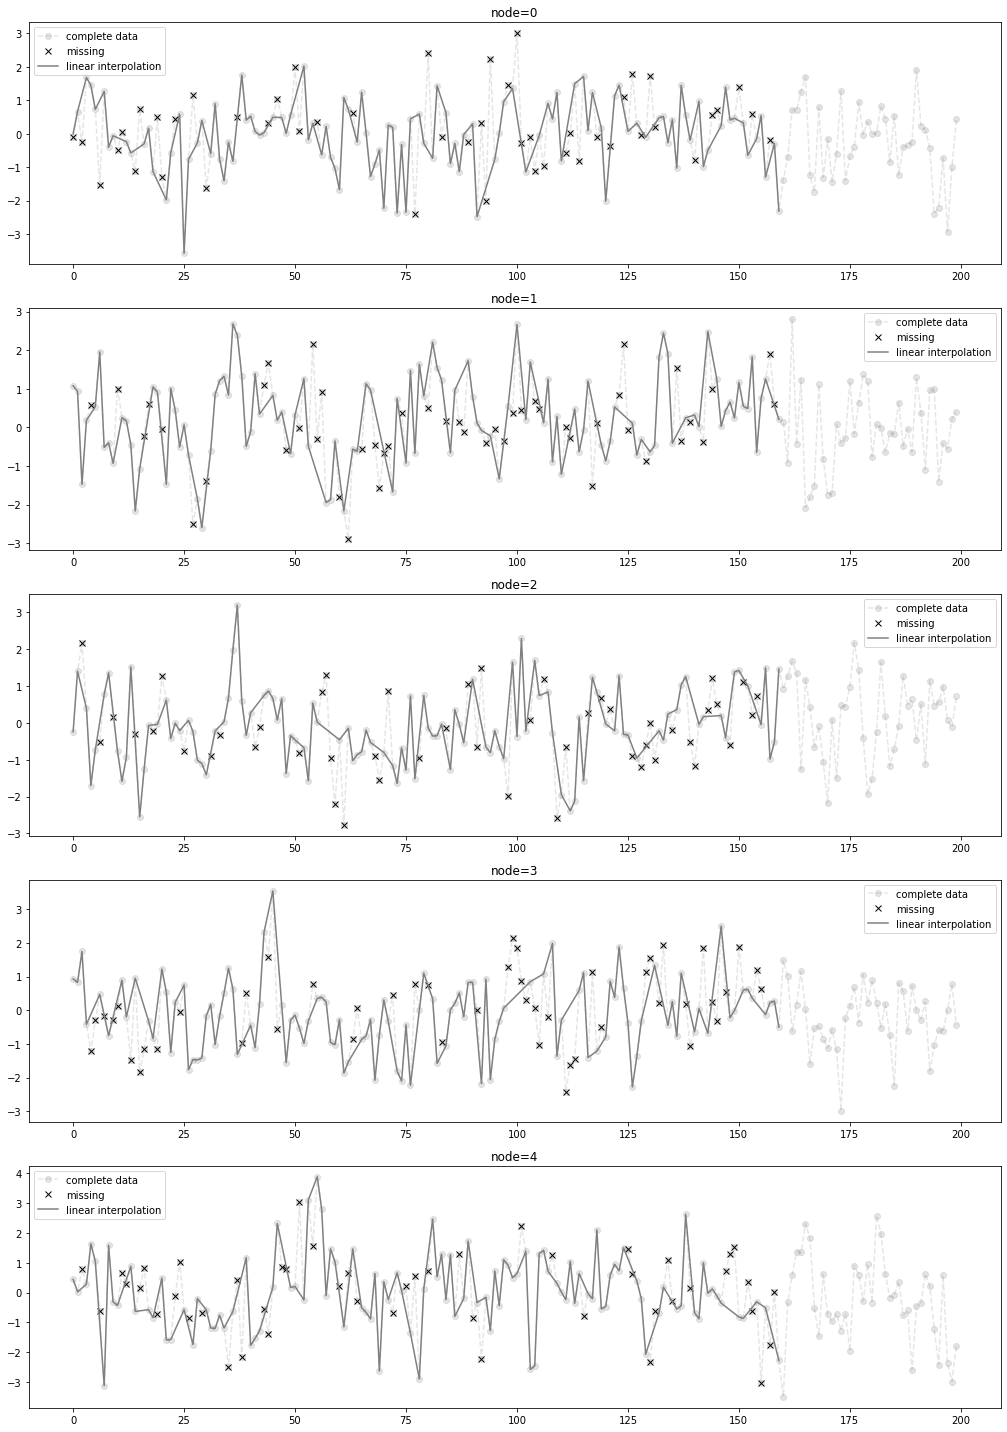

In [208]:
fig = plot(fiveVTS,'--o',h=4,color='gray',label='complete data',alpha=0.2)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.legend()
fig.set_figwidth(15)
fig

### STGCN 으로 적합 + 예측

In [209]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [210]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

In [211]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
for epoch in tqdm(range(50)):
    for time, (xt,yt) in enumerate(zip(X,y)):
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [00:27<00:00,  1.85it/s]

In [212]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [213]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_stgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_stgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_stgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_stgcn = (((yy-yyhat).squeeze())**2).mean()

In [214]:
stgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
stgcn_test = yyhat.squeeze() 

### ESTGCN 으로 적합 + 예측

In [215]:
X = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
y = torch.tensor(interpolated_signal).reshape(int(T*0.8),N,1).float()[1:,:,:]

In [216]:
XX = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[:-1,:,:]).float()
yy = torch.tensor(fiveVTS_test.reshape(int(T*0.2),N,1)[1:,:,:]).float()

`-` ESTGCN

In [217]:
net = RecurrentGCN(node_features=1, filters=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
net.train()
signal = interpolated_signal.copy()
for epoch in tqdm(range(50)):
    signal = update_from_freq_domain(signal,missing_index)
    X = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[:int(T*0.8-1),:,:]
    y = torch.tensor(signal).reshape(int(T*0.8),N,1).float()[1:,:,:]
    for time, (xt,yt) in enumerate(zip(X,y)):        
        yt_hat = net(xt, edge_index, edge_attr)
        cost = torch.mean((yt_hat-yt)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    signal = torch.concat([X.squeeze(),yt_hat.detach().squeeze().reshape(1,-1)])        

100%|██████████| 50/50 [00:27<00:00,  1.79it/s]

In [218]:
yhat = torch.stack([net(xt, edge_index, edge_attr) for xt in X]).detach().numpy()
yyhat = torch.stack([net(xt, edge_index, edge_attr) for xt in XX]).detach().numpy()

In [219]:
real_y = torch.tensor(fiveVTS_train).reshape(int(T*0.8),N,1).float()[1:,:,:]

train_mse_eachnode_estgcn = (((real_y-yhat).squeeze())**2).mean(axis=0)
train_mse_total_estgcn = (((real_y-yhat).squeeze())**2).mean()
test_mse_eachnode_estgcn = (((yy-yyhat).squeeze())**2).mean(axis=0)
test_mse_total_estgcn = (((yy-yyhat).squeeze())**2).mean()

In [220]:
estgcn_train = yhat.squeeze() # stgcn은 stgcn에 의한 적합결과를 의미함
estgcn_test = yyhat.squeeze() 

### GNAR 으로 적합 + 예측

`-`

In [221]:
X_train1 = np.array(X).squeeze()
X_test1 =  np.array(XX).squeeze()

In [222]:
%R -i X_train1

In [223]:
%%R
answer <- GNARfit(vts = X_train1, net = fiveNet, alphaOrder = 1, betaOrder = c(1))
prediction <- predict(answer,n.ahead=40)

In [224]:
%%R
gnar_train <- residuals(answer)
gnar_test <- prediction

In [225]:
%R -o gnar_train
%R -o gnar_test

In [226]:
train_mse_eachnode_gnar = (gnar_train**2).mean(axis=0)
train_mse_total_gnar = (gnar_train**2).mean()
test_mse_eachnode_gnar = ((X_test1 - gnar_test[1:,:])**2).mean(axis=0)
test_mse_total_gnar = ((X_test1 - gnar_test[1:,:])**2).mean()

### 결과시각화

In [227]:
train_mse_total_gnar,test_mse_total_gnar

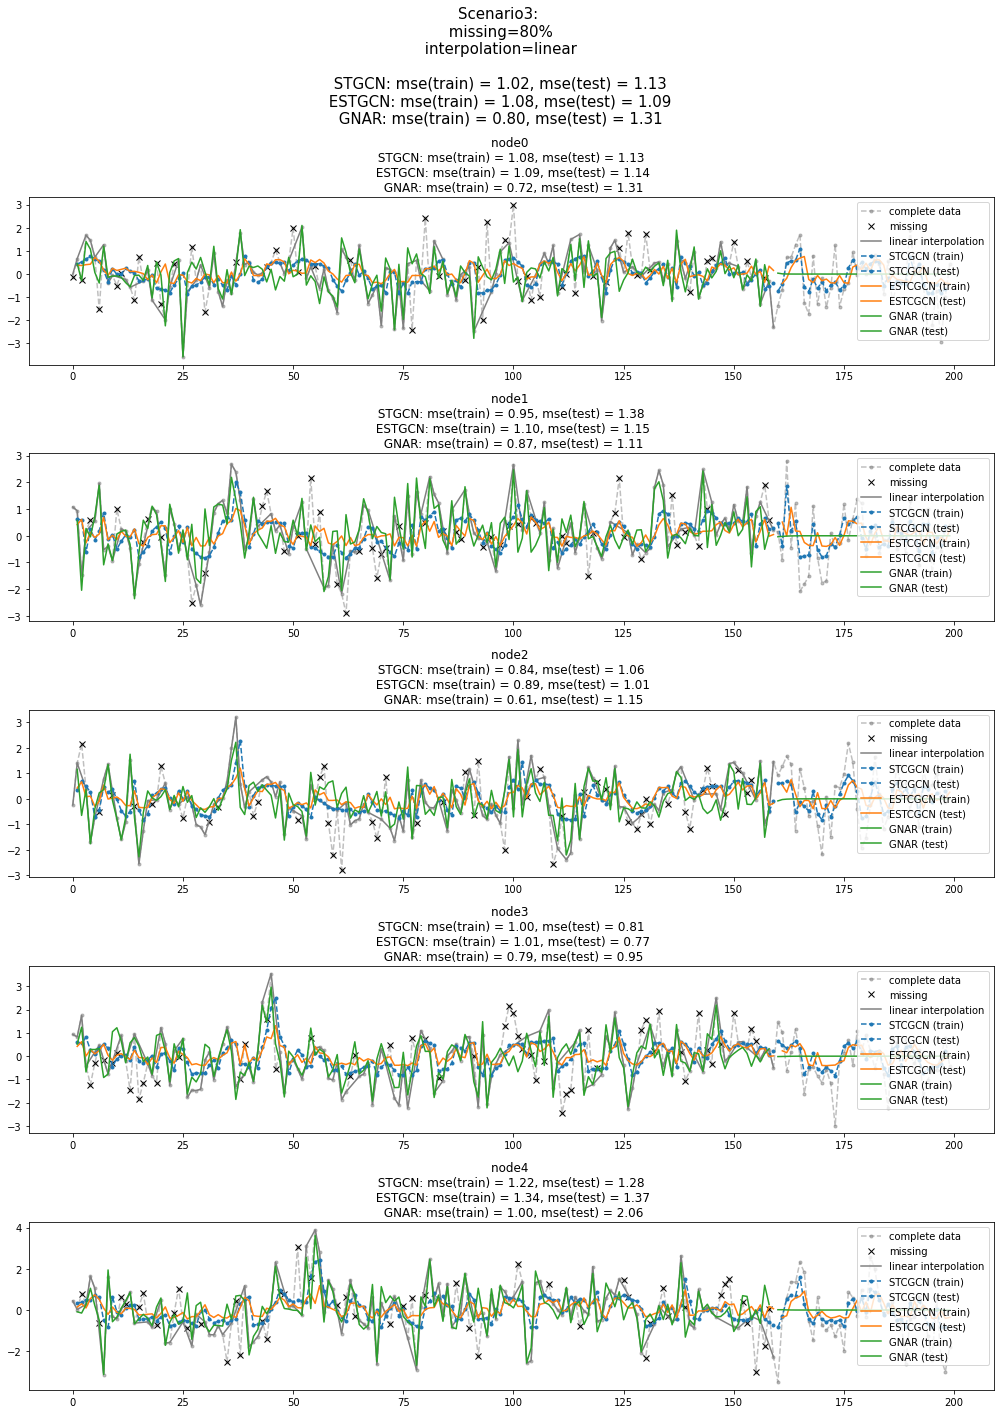

In [228]:
fig = plot(fiveVTS,'--.',h=4,color='gray',label='complete data',alpha=0.5)
ax = fig.get_axes()
for i,a in enumerate(ax):     
    a.set_title('node{0} \n STGCN: mse(train) = {1:.2f}, mse(test) = {2:.2f} \n ESTGCN: mse(train) = {3:.2f}, mse(test) = {4:.2f}\n GNAR: mse(train) = {5:.2f}, mse(test) = {6:.2f}'.format(i,train_mse_eachnode_stgcn[i],test_mse_eachnode_stgcn[i],train_mse_eachnode_estgcn[i],test_mse_eachnode_estgcn[i],train_mse_eachnode_gnar[i],test_mse_eachnode_gnar[i]))
    a.plot(missing_index[i],fiveVTS_train[:,i][missing_index[i]],'xk',label='missing')
    a.plot(interpolated_signal[:,i],'-',color='gray',label='linear interpolation')
    a.plot(range(1,160),stgcn_train.squeeze()[:,i],'--.',label='STCGCN (train)',color='C0')
    a.plot(range(160,199),stgcn_test.squeeze()[:,i],'--.',label='STCGCN (test)',color='C0')
    a.plot(range(1,160),estgcn_train.squeeze()[:,i],label='ESTCGCN (train)',color='C1')
    a.plot(range(161,200),estgcn_test.squeeze()[:,i],label='ESTCGCN (test)',color='C1')
    a.plot(range(1,159),gnar_train[:,i],label='GNAR (train)',color='C2')
    a.plot(range(160,200),gnar_test[:,i],label='GNAR (test)',color='C2')
    
    a.legend()
fig.set_figwidth(14)
fig.suptitle("Scenario3: \n missing=80% \n interpolation=linear \n\n STGCN: mse(train) = {0:.2f}, mse(test) = {1:.2f} \n ESTGCN: mse(train) = {2:.2f}, mse(test) = {3:.2f} \n GNAR: mse(train) = {4:.2f}, mse(test) = {5:.2f} \n".format(train_mse_total_stgcn,test_mse_total_stgcn,train_mse_total_estgcn,test_mse_total_estgcn,train_mse_total_gnar,test_mse_total_gnar),size=15)
fig.tight_layout()
fig